In [2]:
import matplotlib.pyplot as plt
import os
import ogb
import math

import json
import networkx as nx
import pandas as pd
from ogb.linkproppred import PygLinkPropPredDataset

from pact.spasmspace import SpasmSpace
from pact.graphwrapper import GraphWrapper
from pact.ui import default_progressbar
from pact.naive_exec import naive_pandas_plan_exec, _undir_df_degree_thres, sliced_pandas_homcount
import dill
import multiprocess as mp

import random

MAX_THREADS = 20
OUTPUT_FILE = f'collab/collab_clique5_counts.json'
# _SPARSIFY = 50000

BASIS_FILE = f'bases/cliques/clique4_basis.json'


with open(BASIS_FILE, 'rb') as f:
    basis_info = dill.loads(f.read())
spsp = basis_info['SpasmSpace']
Pbasis = basis_info['basis']




In [31]:
basis_order = list(Pbasis.keys())
select_basis = basis_order[9:]

new_basis = {}
for i in select_basis:
    new_basis[i] = Pbasis[i]

In [32]:
new_basis[basis_order[7]] = Pbasis[basis_order[7]]

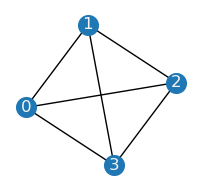

In [43]:
"""
Draw the basis nicely
"""
rows = math.ceil(len(Pbasis)/5)
fig = plt.figure(figsize=(5*2,2*rows))
gs = fig.add_gridspec(nrows=rows, ncols=5)

r,c = 0,0

for gid, alpha in Pbasis.items():
    fig.add_subplot(gs[r,c])
    
    # spsp[gid] is the GraphWrapper object with id = gid
    # the .graph attribute here is the raw networkx object used for drawing
    nx.draw(spsp[gid].graph, node_size=200, with_labels=True, font_color='whitesmoke')
    # plt.title(f'coefficient: {alpha.digits()}\n')
    
    
    c+=1
    if c >= 5:
        r += 1
        c = 0
plt.tight_layout()

# Setup Data

In [3]:
dataset = PygLinkPropPredDataset(name = "ogbl-collab", root = 'dataset/')
data = dataset[0]

In [4]:
edges = [[x.item() for x in e] for e in dataset.get_edge_split()['valid']['edge']]
G = nx.from_edgelist(edges)
print(G.order(), G.size())

def sparsify(sz):
    global G
    subg = random.sample(list(G.nodes), sz)
    G = nx.induced_subgraph(G, subg)
    print(G.order(), G.size())
    
# if _SPARSIFY is not None:
#     sparsify(_SPARSIFY)

23367 60084


In [10]:
# convert a networkx graph and into a pandas DataFrame as expected by the naive plan executer
def nxGtoDf(nxG):
    edges = [{'s': a, 't': b} for a,b in nxG.edges()] + [{'s': b, 't': a} for a,b in nxG.edges()]
    host_df = pd.DataFrame(edges).drop_duplicates()
    return host_df

df = nxGtoDf(G)
#del G

# Actual Implementation for Sliced Counting of Homomorphisms

In [11]:
from pact.operation import Operation

def suggest_slice_var(P):
    plan = P.plan
    slice_var_guess = 0
    for op in plan:
        if op.kind != Operation.JOIN:
            continue
        slice_var_guess = list(op.key)[0]
        break
        
    if P.cycle is not None and P.cycle > 4:
        for op in reversed(plan):
            if op.kind != Operation.JOIN:
                continue
            if 'node$' in op.A:
                slice_var_guess = list(op.key)[0]
    return slice_var_guess

def sliced_counts(pattern, host, progress=None, slice_var=0, interval_size=200, threads=3):
    THREADS = threads
    _MARK_VTX=0

    def homcounts_per_vertex(F, host_df, slicer):
        state, empty = naive_pandas_plan_exec(F.plan, host_df, sliced_eval=slicer)
        if not empty:
            finalcount = state['node$0']
            key = _MARK_VTX
            return finalcount.groupby(key)['count'].sum().to_dict()
        else:
            return {}

    def _helper(interval):
        lo, hi = interval
        slicer = {slice_var: (lo, hi)}
        return homcounts_per_vertex(pattern, host, slicer=slicer,)

    if (not pattern.is_directed and hasattr(pattern, 'clique') and
        pattern.clique is not None and pattern.clique > 2):
        host = _undir_df_degree_thres(host, pattern.clique - 1)


    top = host.max().max()
    steps = list(range(0, top, interval_size)) + [None]
    intervals = list(zip(steps, steps[1:]))
    
    if progress is None:
        progress = default_progressbar()

    acc = {}
    with progress as localp:
        pool = mp.Pool(THREADS)
        track = localp.track(pool.imap_unordered(_helper, intervals),
                                   total=len(intervals))
        for slice_count in track:
            for vertex, vcount in slice_count.items():
                acc[vertex] = acc.get(vertex,0)+vcount
    return acc

def _local_test():
    slice_var = suggest_slice_var(P)
    if P.ghw == 1:
        interval_size = 10000
    elif P.ghw >= 2:
        interval_size = 200

    _ = sliced_counts(P, df.iloc[:10],
                      slice_var=slice_var, interval_size=interval_size, threads=1)
    print(f'(sliced on {slice_var})')

# Counting Happens down here

In [44]:
print('Size of basis:', len(Pbasis))

Size of basis: 1


In [45]:
ordered_basis = [pid for pid in Pbasis.keys()]

allcounts = {v: [] for v in G.nodes}
with default_progressbar() as progress:
    for pid in ordered_basis:
        P = spsp[pid]
        slice_var = suggest_slice_var(P)
        if P.ghw == 1:
            interval_size = 10000
        else: interval_size = 200
        Pcounts = sliced_counts(P, df, progress,
                                slice_var=slice_var, interval_size=interval_size,
                                threads=MAX_THREADS)
        for k in allcounts.keys():
            allcounts[k].append(Pcounts.get(k,0))
            
with open(OUTPUT_FILE, 'w') as f:
    f.write(json.dumps(allcounts))

Output()